In [7]:
from pydantic import BaseModel, Field
from typing import Literal
import ollama
import json

class TicketAnalysis(BaseModel):
    intent: Literal["refund", "tech_support", "billing", "feedback"] = Field(
        description="The core reason for the ticket."
    )
    urgency: Literal["low", "medium", "high"] = Field(
        description="How fast do we need to reply?"
    )
    sentiment_score: int = Field(
        ge=1, le=5, description="1 is very angry, 5 is very happy.")

In [8]:
schema = TicketAnalysis.model_json_schema()
print(json.dumps(schema, indent=2))

{
  "properties": {
    "intent": {
      "description": "The core reason for the ticket.",
      "enum": [
        "refund",
        "tech_support",
        "billing",
        "feedback"
      ],
      "title": "Intent",
      "type": "string"
    },
    "urgency": {
      "description": "How fast do we need to reply?",
      "enum": [
        "low",
        "medium",
        "high"
      ],
      "title": "Urgency",
      "type": "string"
    },
    "sentiment_score": {
      "description": "1 is very angry, 5 is very happy.",
      "maximum": 5,
      "minimum": 1,
      "title": "Sentiment Score",
      "type": "integer"
    }
  },
  "required": [
    "intent",
    "urgency",
    "sentiment_score"
  ],
  "title": "TicketAnalysis",
  "type": "object"
}


In [9]:
raw_ticket = "I've been charged twice for my subscription and no one is answering the phones. Fix this or I'm leaving!"

response = ollama.chat(
    model='phi4-mini',
    messages=[
        {'role': 'system', 'content': 'You are a support bot. Categorize accurately.'},
        {'role': 'user', 'content': raw_ticket}
    ],
    format=schema, 
    options={'temperature': 0} 
)

analysis = TicketAnalysis.model_validate_json(response.message.content)

print(f"Detected Intent: {analysis.intent}")
print(f"Urgency Level: {analysis.urgency}")
print(f"Sentiment (1-5): {analysis.sentiment_score}")

Detected Intent: billing
Urgency Level: high
Sentiment (1-5): 2


In [10]:
import sys
import os

project_root = os.path.abspath(os.path.join(os.getcwd(), '..'))

if project_root not in sys.path:
    sys.path.append(project_root)

from src.core.classifier import triage_ticket
from src.models.ticket_schema import CategorizedTicket

test_ticket = "I am very upset because I was charged $50 twice on my credit card!"
result = triage_ticket(test_ticket)

if result:
    print(f"Intent: {result.intent}")
    print(f"Priority: {result.priority}")
    print(f"AI Summary: {result.summary}")

Intent: Billing inquiry
Priority: High
AI Summary: Customer experiencing double-charging issue with their credit card, resulting in an unexpected charge.


In [11]:
import pandas as pd
import ollama
import json
from pydantic import BaseModel, Field
from typing import Literal
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

class TicketEvaluation(BaseModel):
    intent: Literal["Technical issue", "Billing inquiry", "Cancellation request", "Product inquiry", "Refund request"] = Field(
        description="The primary category of the ticket."
    )
    priority: Literal["Critical", "High", "Medium", "Low"] = Field(
        description="Priority level of the ticket."
    )
    summary: str = Field(description="1-sentence summary.")

df = pd.read_csv(r'C:\Users\khura\Desktop\Projects\Tickets Triage\data\synthetic_tickets_hard.csv')

In [ ]:
sample_df = df.head(20 ).copy()
ai_intents = []
ai_priorities = []

print("🚀 Starting AI Triage on Sample Data...")

for i, row in sample_df.iterrows():
    try:
        response = ollama.chat(
            model='phi4-mini',
            messages=[{'role': 'user', 'content': f"Categorize this: {row['Ticket Description']}"}],
            format=TicketEvaluation.model_json_schema(),
            options={'temperature': 0}
        )
        
        analysis = TicketEvaluation.model_validate_json(response.message.content)
        ai_intents.append(analysis.intent)
        ai_priorities.append(analysis.priority)
        print(f"✅ Ticket {i+1} processed.")
        
    except Exception as e:
        print(f"❌ Error on {i}: {e}")
        ai_intents.append(None)
        ai_priorities.append(None)

sample_df['AI_Intent'] = ai_intents
sample_df['AI_Priority'] = ai_priorities

sample_df = sample_df.dropna(subset=['AI_Intent'])


🚀 Starting AI Triage on Sample Data...
✅ Ticket 1 processed.
✅ Ticket 2 processed.
✅ Ticket 3 processed.
✅ Ticket 4 processed.
✅ Ticket 5 processed.
✅ Ticket 6 processed.
✅ Ticket 7 processed.
✅ Ticket 8 processed.
✅ Ticket 9 processed.
✅ Ticket 10 processed.
✅ Ticket 11 processed.
✅ Ticket 12 processed.
✅ Ticket 13 processed.
✅ Ticket 14 processed.
✅ Ticket 15 processed.
✅ Ticket 16 processed.
✅ Ticket 17 processed.
✅ Ticket 18 processed.
✅ Ticket 19 processed.
✅ Ticket 20 processed.



--- INTENT ACCURACY REPORT ---
                      precision    recall  f1-score   support

     Billing inquiry       0.80      0.67      0.73         6
Cancellation request       0.67      1.00      0.80         2
     Product inquiry       0.40      0.50      0.44         4
      Refund request       1.00      1.00      1.00         3
     Technical issue       1.00      0.80      0.89         5

            accuracy                           0.75        20
           macro avg       0.77      0.79      0.77        20
        weighted avg       0.79      0.75      0.76        20



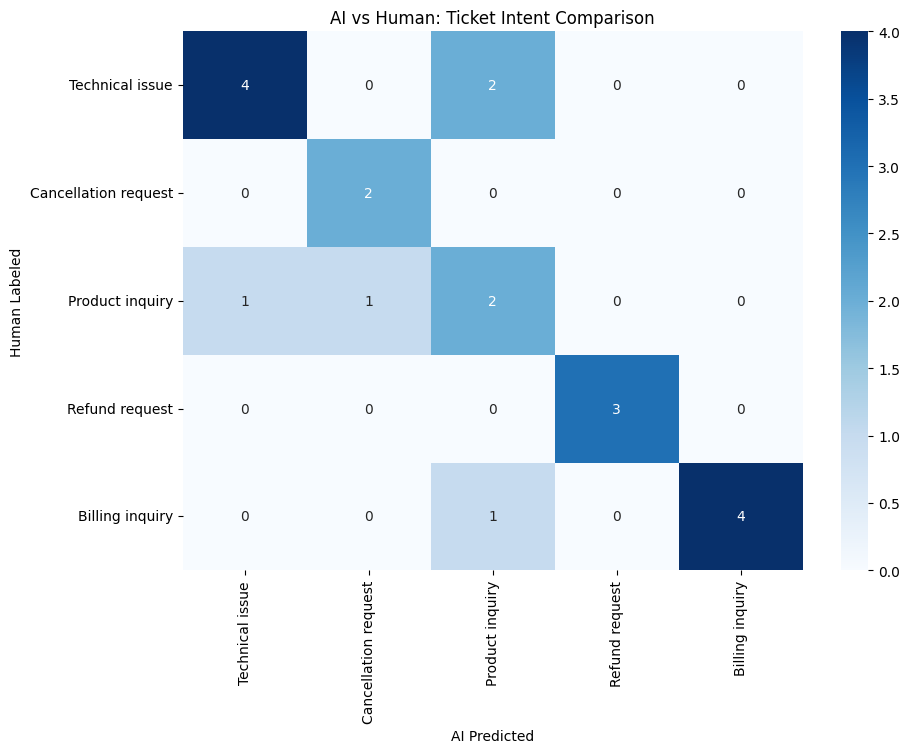

In [13]:
print("\n--- INTENT ACCURACY REPORT ---")
print(classification_report(sample_df['Ticket Type'], sample_df['AI_Intent']))

plt.figure(figsize=(10,7))
cm = confusion_matrix(sample_df['Ticket Type'], sample_df['AI_Intent'])
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=sample_df['AI_Intent'].unique(), 
            yticklabels=sample_df['Ticket Type'].unique())
plt.title('AI vs Human: Ticket Intent Comparison')
plt.xlabel('AI Predicted')
plt.ylabel('Human Labeled')
plt.show()
